# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [ ]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python
# !pip install pillow

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

2024-12-04 15:32:25.514153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 15:32:25.554989: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 15:32:25.556025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 15:32:26.312916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
image_labels = [
  "Paubha Painting",
  "Thangka Painting",
  "Mithila Painting",
  "Mandala Art",
  "Pata Painting",
  "Cave Paintings",
  "Wall Murals",
  "Miniature Paintings",
  "Newari Scroll Paintings",
  "Kalash Decoration Paintings",
  "Astamangal Symbol Art",
  "Buddhist Deity Paintings",
  "Hindu Deity Paintings",
  "Nature Motif Paintings",
  "Narrative Mythological Paintings",
  "Ritual Floor Paintings (Mandap Art)",
  "Bodhisattva Paintings",
  "Chakra Symbolism Art",
  "Animal and Bird Motif Paintings",
  "Tantric Paintings",
  "Cosmological Chart Paintings",
  "Agricultural Folk Art Paintings",
  "Festive Theme Paintings",
  "Ceremonial Face Paintings",
  "Temple Frescoes",
  "Bhajan Mandali Scene Art",
  "Storyline Scroll Paintings",
  "Handmade Paper Art Paintings"
]


In [ ]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Validate ratios
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Train, validation, and test ratios must sum to 1.")
    
    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)
    
    # Iterate over each class folder
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Get all files in the class folder
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Split files into train, validation, and test sets
        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Copy files to destination directories
        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_class_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
    
    print("Data successfully split into train, validation, and test sets.")

# Example usage:
source_directory = "/workspaces/machine-learning/projects/folk-art-classification/dataset"
destination_directory = "./data-set"

# split_data(source_directory, destination_directory)

Data successfully split into train, validation, and test sets.


In [ ]:
def convert_images_to_jpg(dataset_dir):
    # Supported extensions for conversion (excluding .svg)
    supported_extensions = ['.jpeg', '.png', '.gif', '.webp']

    # Traverse through the dataset directory
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            file_name, file_ext = os.path.splitext(file)

            # Check if the file is an SVG
            if file_ext.lower() == '.svg':
                try:
                    os.remove(file_path)  # Delete the SVG file
                    print(f"Deleted SVG file: {file_path}")
                except Exception as e:
                    print(f"Error deleting SVG file {file_path}: {e}")
                continue  # Skip further processing for this file
            
            # Process other supported image types
            if file_ext.lower() in supported_extensions or file_ext.lower() == '.jpg':
                try:
                    # Open the image
                    img = Image.open(file_path).convert('RGB')
                    
                    # New file path with the same directory but `.jpg` extension
                    new_file_path = os.path.join(root, f"{file_name}.jpg")
                    
                    # Save the image as `.jpg`
                    img.save(new_file_path, 'JPEG')
                    
                    # Delete the original file only if it's not already `.jpg`
                    if file_ext.lower() != '.jpg':
                        os.remove(file_path)
                    
                    print(f"Converted and replaced: {file_path} -> {new_file_path}")
                except Exception as e:
                    print(f"Error converting {file_path}: {e}")

# Example usage
dataset_directory = "./data-set"
# convert_images_to_jpg(dataset_directory)


In [25]:
img_size = (128, 128)
batch_size = 32

In [26]:
# Paths to dataset directories
train_dir = '/workspaces/machine-learning/projects/folk-art-classification/data-set/train'
val_dir = '/workspaces/machine-learning/projects/folk-art-classification/data-set/val'
test_dir = '/workspaces/machine-learning/projects/folk-art-classification/data-set/test'

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [28]:
def preprocess(image, label, augment=False):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    if augment:
        image = data_augmentation(image)  # Apply data augmentation if specified
    return image, label

In [29]:
def prepare_dataset(directory, augment=False, shuffle=True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',        # Infer labels from subdirectory names
        label_mode='categorical', # One-hot encoded labels
        image_size=img_size,      # Resize images
        batch_size=batch_size,    # Number of images per batch
        shuffle=shuffle           # Shuffle data (disable for test dataset)
    )
    dataset = dataset.map(lambda x, y: preprocess(x, y, augment=augment))  # Apply preprocessing
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance


In [30]:
train_dataset = prepare_dataset(train_dir, augment=True, shuffle=True)  # Augmentation enabled
val_dataset = prepare_dataset(val_dir, augment=False, shuffle=True)    # No augmentation
test_dataset = prepare_dataset(test_dir, augment=False, shuffle=True) 

Found 14129 files belonging to 28 classes.


Found 3036 files belonging to 28 classes.
Found 3040 files belonging to 28 classes.


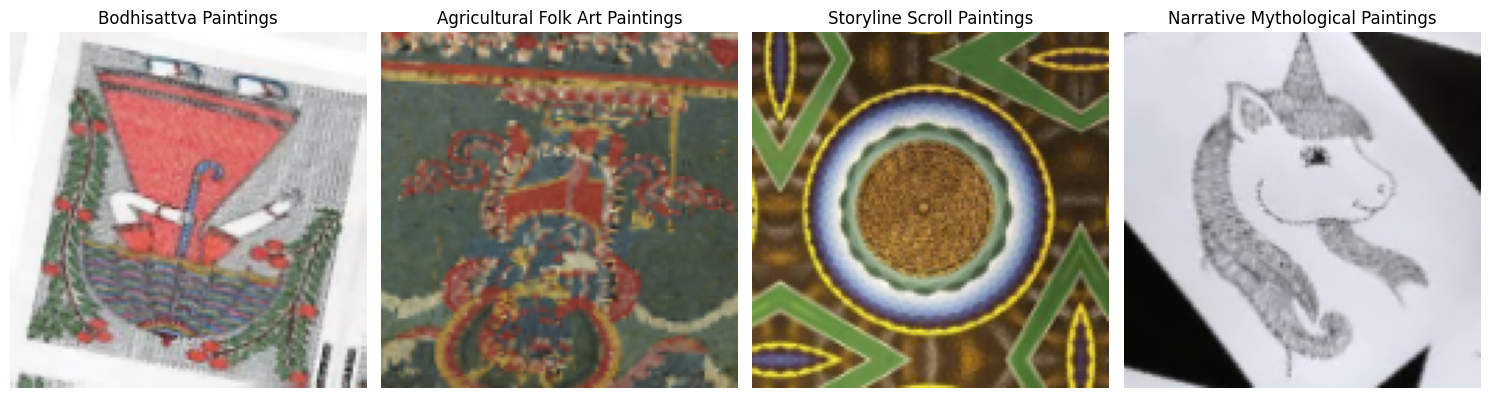

In [31]:
# Fetch a batch of images and labels from the training dataset
images, labels = next(iter(train_dataset))  # `train_dataset` is from the updated pipeline

# Define the number of images to display
num_images = 4
plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization

# Loop through the number of images to display
for index in range(num_images):
    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image
    plt.imshow(images[index].numpy())  # Display the image (convert Tensor to NumPy)
    class_label = labels[index].numpy().argmax()  # Get the class index from one-hot encoding
    class_name = image_labels[class_label]  # Get class name
    plt.title(class_name)  # Set the title to the class name
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [32]:
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(28, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [34]:
# Define the log directory
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=4,                # Number of epochs to wait before stopping
    restore_best_weights=True  # Restores the weights of the best epoch
)

In [36]:
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 28)


In [ ]:
history = model.fit(
    train_dataset,                # Training dataset
    epochs=10,                    # Adjust epochs as needed
    validation_data=val_dataset,  # Validation dataset
    callbacks=[tensorboard_callback, early_stopping]  # Include callbacks
)

Epoch 1/10


 53/442 [==>...........................] - ETA: 11:53 - loss: 3.3722 - accuracy: 0.0607

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
model.save('art-classification-v4.h5')

In [ ]:
# model = load_model('./model/art-classification-v2.h5')

In [ ]:
test_images, test_labels = next(iter(test_dataset))

In [ ]:
img_predict = model.predict(test_images)

In [ ]:
np.argmax(test_labels[0])

In [ ]:
np.argmax(img_predict[0])

In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)  # Create a grid of subplots (2 rows, 4 columns)
    plt.imshow(test_images[i], cmap="gray")  # Display the image in grayscale
    
    # Get predicted and true class names
    predicted_class = class_labels[np.argmax(img_predict[i])]
    true_class = class_labels[np.argmax(test_labels[i])]
    
    # Display predicted and true class names
    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)
    plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()
